created by Ignacio Oguiza - email: oguiza@gmail.com

# How to work with numpy arrays in fastai2: time series classification

I'd like to share with you how you can work with (very large) numpy arrays in **fastai2** through a time series classification example. In this case we'll use a multivariate time series dataset.

**High level requirements:**

- Be able to work with *numpy arrays with any number of dimensions*. 
- Data may be *larger than RAM*, so it may be in memory or on disk.
- Use data on disk with similar *performance* to data in memory.
- Data is often *split*: 
    - X, y
    - X_train, X_valid, y_train, y_valid
- Add an *unlabeled dataset* (for example for semi-supervised/ self-supervised learning).
- Add test dataset.

The code I show here is what you may need to customize to use your own data if they are not time series.

## Import libraries 📚

In [1]:
from nbdev.showdoc import *
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
from fastai2.torch_core import *
from fastai2.data.all import *
from fastai2.learner import *
from fastai2.metrics import *

In [3]:
from timeseries.imports import *
from timeseries.utils import *
from timeseries.data import *
#from timeseries.core import *
from timeseries.models import *

## Prepare data 🔢

In this notebook, we'll use one of the most widely used time series classification databases: UEA & UCR Time Series Classification Repository. As of Sep 2019 it contains 128 univariate datasets and 30 multivariate datasets.

In [4]:
pprint.pprint(get_UCR_univariate_list())

['ACSF1',
 'Adiac',
 'AllGestureWiimoteX',
 'AllGestureWiimoteY',
 'AllGestureWiimoteZ',
 'ArrowHead',
 'Beef',
 'BeetleFly',
 'BirdChicken',
 'BME',
 'Car',
 'CBF',
 'Chinatown',
 'ChlorineConcentration',
 'CinCECGTorso',
 'Coffee',
 'Computers',
 'CricketX',
 'CricketY',
 'CricketZ',
 'Crop',
 'DiatomSizeReduction',
 'DistalPhalanxOutlineAgeGroup',
 'DistalPhalanxOutlineCorrect',
 'DistalPhalanxTW',
 'DodgerLoopDay',
 'DodgerLoopGame',
 'DodgerLoopWeekend',
 'Earthquakes',
 'ECG200',
 'ECG5000',
 'ECGFiveDays',
 'ElectricDevices',
 'EOGHorizontalSignal',
 'EOGVerticalSignal',
 'EthanolLevel',
 'FaceAll',
 'FaceFour',
 'FacesUCR',
 'FiftyWords',
 'Fish',
 'FordA',
 'FordB',
 'FreezerRegularTrain',
 'FreezerSmallTrain',
 'Fungi',
 'GestureMidAirD1',
 'GestureMidAirD2',
 'GestureMidAirD3',
 'GesturePebbleZ1',
 'GesturePebbleZ2',
 'GunPoint',
 'GunPointAgeSpan',
 'GunPointMaleVersusFemale',
 'GunPointOldVersusYoung',
 'Ham',
 'HandOutlines',
 'Haptics',
 'Herring',
 'HouseTwenty',
 'Inli

In [5]:
pprint.pprint(get_UCR_multivariate_list())

['ArticularyWordRecognition',
 'AtrialFibrillation',
 'BasicMotions',
 'CharacterTrajectories',
 'Cricket',
 'DuckDuckGeese',
 'EigenWorms',
 'Epilepsy',
 'ERing',
 'EthanolConcentration',
 'FaceDetection',
 'FingerMovements',
 'HandMovementDirection',
 'Handwriting',
 'Heartbeat',
 'InsectWingbeat',
 'JapaneseVowels',
 'Libras',
 'LSST',
 'MotorImagery',
 'NATOPS',
 'PEMS-SF',
 'PenDigits',
 'PhonemeSpectra',
 'RacketSports',
 'SelfRegulationSCP1',
 'SelfRegulationSCP2',
 'SpokenArabicDigits',
 'StandWalkJump',
 'UWaveGestureLibrary']


In the case of UCR data it's very easy to get data loaded. Let's select a dataset. You can modify this and select any one from the previous lists (univariate of multivariate).

This framework I'm using can deal with numpy arrays on disk (np.memmap). If you are not familiar with them, you may want to take a look at the 00_How_to_efficiently_work_with_very_large_numpy_arrays.ipynb I've also shared.

In [6]:
# dataset id
dsid = 'NATOPS'   # ✳️

In [7]:
X_train, y_train, X_valid, y_valid = get_UCR_data(dsid, verbose=True, on_disk=True)

Dataset: NATOPS
X_train: (180, 24, 51)
y_train: (180,)
X_valid: (180, 24, 51)
y_valid: (180,) 



In [8]:
X_train.__class__

numpy.memmap

☣️ **Something very important when you prepare your own data is that data needs to be in a 3-d array with the following format:**

1. Samples
2. Variables (1 for univariate or several for multivariate)
3. Length (aka timesteps)


All UEA & UCR Time Series Classification data have already been split between train and valid. When you use your own data, you'll have to split it yourself. We'll see examples of this in future notebooks.

### Building block: TSTensor

Since fastai is based on Pytorch, you'll need to somehow convert the numpy arrays to tensors at some point (TSTensor in out case). There's a transform function called ToTSTensor that transforms an array into a tensor of type TSTensor (which has a show method).

If you don't use time series, you may want to modify TSTensor and ToTSTensor to meet your needs. 

In [9]:
class TSTensor(TensorBase):

    @classmethod
    def create(cls, o): return cls(To2DPlusTensor(o)) # creates a TSTensor with at least 2 dims of type float

    @property
    def vars(self): return self.shape[-2]

    @property
    def len(self): return self.shape[-1]
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        return retain_type(res, self)

    def __repr__(self):
        return f'TSTensor(size:{list(self.size())})'

    def show(self, ax=None, ctx=None, title=None, **kwargs):
        ax = ifnone(ax,ctx)
        if ax is None: fig, ax = plt.subplots(**kwargs)
        ax.plot(self.T)
        ax.axis(xmin=0, xmax=self.shape[-1] - 1)
        ax.set_title(title, weight='bold')
        plt.tight_layout()
        return ax

@Transform
def ToTSTensor(o:np.ndarray): 
    """ np.ndarray to tensor of dtype torch.float32"""
    return TSTensor.create(o)

In [10]:
t = ToTSTensor(X_train[0])
t

TSTensor(size:[24, 51])

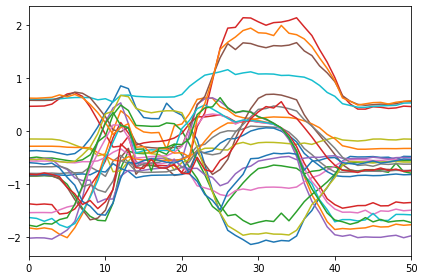

In [11]:
t.show();

In [12]:
t.vars, t.len, t.dtype

(24, 51, torch.float32)

### NumpyDatasets

Next thing we need in fastai2 is a was to create datasets. I've adapted fastai's Dataset so that it can take numpy arrays.

In [13]:
class NumpyDatasets(FilteredBase):
    "A dataset that creates a tuple from each `tfms`, passed thru `item_tfms`"
    def __init__(self, X=None, y=None, items=None, tfms=None, tls=None, n_inp=None, dl_type=None, pre_process=True, **kwargs):
        super().__init__(dl_type=dl_type)

        if tls is None:
            if items is None: items = itemify(X,) if y is None else itemify(X,y)
            n_items = len(items[0])
            assert (tfms is None or n_items == len(tfms)), f"n_tfms ({len(tfms)}) doesn't match n_items ({n_items})"
            process = [False] * (n_items - 1) + [pre_process] if items[0][0].__class__.__name__ == 'memmap' else [pre_process] * (n_items)
            tfms = [None] if tfms is None else [[ItemGetter(i)] + L(tfms[i]) for i in range(n_items)]
        self.tls = L(tls if tls else [pre_process_TL(TfmdLists(items, t, **kwargs), p, **kwargs) for p, t in zip(process, tfms)])
        self.n_inp = (1 if len(self.tls)==1 else len(self.tls)-1) if n_inp is None else n_inp

    def __getitem__(self, it):
        if len(self.tls) == 1: return self.tls[0][it]
        res = tuple([tl[it] for tl in self.tls])
        return res if is_indexer(it) else list(zip(*res))

    def __getattr__(self,k): return gather_attrs(self, k, 'tls')
    def __dir__(self): return super().__dir__() + gather_attr_names(self, 'tls')
    def __len__(self): return len(self.tls[0])
    def __iter__(self): return (self[i] for i in range(len(self)))
    def __repr__(self): return coll_repr(self)
    def decode(self, o, full=True): return tuple(tl.decode(o_, full=full) for o_,tl in zip(o,tuplify(self.tls, match=o)))
    def subset(self, i): return type(self)(tls=L(tl.subset(i) for tl in self.tls), n_inp=self.n_inp)
    def _new(self, items, *args, **kwargs): return super()._new(items, tfms=self.tfms, do_setup=False, **kwargs)
    def overlapping_splits(self): return self.tls[0].overlapping_splits()
    @property
    def splits(self): return self.tls[0].splits
    @property
    def split_idx(self): return self.tls[0].tfms.split_idx
    @property
    def items(self): return self.tls[0].items
    @items.setter
    def items(self, v):
        for tl in self.tls: tl.items = v

    def show(self, o, ctx=None, **kwargs):
        for o_,tl in zip(o,self.tls): ctx = tl.show(o_, ctx=ctx, **kwargs)
        return ctx

    def new_empty(self):
        tls = [tl._new([], split_idx=tl.split_idx) for tl in self.tls]
        return type(self)(tls=tls, n_inp=self.n_inp)

    @contextmanager
    def set_split_idx(self, i):
        old_split_idx = self.split_idx
        for tl in self.tls: tl.tfms.split_idx = i
        yield self
        for tl in self.tls: tl.tfms.split_idx = old_split_idx
            

def pre_process_TL(tfmdlists, process=True, **kwargs): 
    if process: return TfmdLists(tfmdlists[:], None, **kwargs)
    else: return tfmdlists

NumpyDatasets only takes X and y, not X_train, y_train, X_valid, y_valid.

Since data is already split between train and test in the UCR dataset, we are going to merge them and create some indices to split them in the same sets.

As I also want to demonstrate how you can use numpy arrays on disk, I'll merge data and save it to simulate you have an array on disk.

In [14]:
X = np.concatenate((X_train, X_valid))
y = np.concatenate((y_train, y_valid))
folder = 'data/UCR'
np.save(str(PATH.parent/f'{folder}/{dsid}/X.npy'), X) # cannot use pathlib.PosixPath as filename 
np.save(str(PATH.parent/f'{folder}/{dsid}/y.npy'), y)
del X, y
X = np.load(str(PATH.parent/f'{folder}/{dsid}/X.npy'), mmap_mode='r')
y = np.load(str(PATH.parent/f'{folder}/{dsid}/y.npy'), mmap_mode='r')
splits = (L(list(np.arange(len(X_train)))), L(list(np.arange(len(X_train), len(X)))))
X.shape, y.shape

((360, 24, 51), (360,))

As we have used a mmap_mode when loading data, the numpy array class is np.memmap (it means data is being read directly from memory).

In [15]:
X.__class__

numpy.memmap

Let's now build the datasets. We are going to use 2 transforms: 

- ToTSTensor: to convert X array into a TSTensor
- Categorize(): to create a tensor label based on a dictionary of unique classes

Since most of the transforms perform with arrays are deterministic (they are not random, and always deliver the same output), I've also included a pre_process option that as you will see speeds up the dataloader.

These are item transforms in fastai2 since we need to perform them at the item level, before a batch is created as the input to a batch needs to be tensors.

In [16]:
tfms = [[ToTSTensor], [Categorize()]]
dsets = NumpyDatasets(X, y, tfms=tfms, splits=splits, pre_process=True)

In [17]:
dsets[0]

(TSTensor(size:[24, 51]), TensorCategory(3))

As you can see the numpy arrays have been transformed into tensors. However, the X data (that may be larger than RAM) is still on disk. Data conversion occurs only on demand. When a batch needs to be created, the random selected samples are brought into memory and transformed into a tensor. this process occurs very quickly as I also showed in the 00 tutorial notebook. In this way you can efficiently use large numpy arrays with fastai2.

In [18]:
dsets[0][0], dsets[0][0].data

(TSTensor(size:[24, 51]),
 tensor([[-0.3728, -0.3678, -0.3784,  ..., -0.5370, -0.4759, -0.4795],
         [-1.8217, -1.8420, -1.8214,  ..., -1.7513, -1.7724, -1.7616],
         [-0.8463, -0.8463, -0.8396,  ..., -0.6037, -0.7630, -0.7932],
         ...,
         [ 0.6192,  0.6170,  0.6248,  ...,  0.5413,  0.5593,  0.5716],
         [-1.7718, -1.7967, -1.7386,  ..., -1.6917, -1.6831, -1.7217],
         [-0.8101, -0.8189, -0.7881,  ..., -0.7164, -0.7575, -0.7415]]))

In [19]:
len(dsets.train), len(dsets.valid)

(180, 180)

In [20]:
dsets.tls[0].tfms, dsets.tls[1].tfms

(Pipeline: itemgetter -> ToTSTensor, Pipeline: )

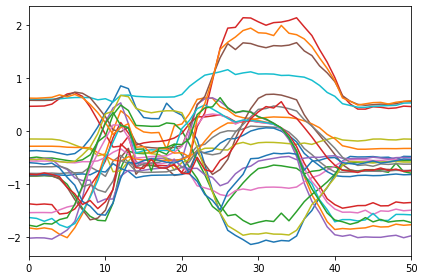

In [21]:
dsets.show(dsets.train[0]);

### Dataloaders

For convenience, I've also adapted the dataloader to work more easily with time series. But most of the functionality is still the original fastai2.

In [22]:
#export
class TSTfmdDL(TfmdDL): 

    @property
    def vars(self): return self.dataset[0][0].shape[-2]
    
    @property
    def len(self): return self.dataset[0][0].shape[-1]

    @delegates(plt.subplots)
    def show_batch(self, b=None, max_n=9, nrows=3, ncols=3, figsize=(12, 10), **kwargs):
        if b is None: b = self.one_batch()
        db = self.decode_batch(b, max_n=max_n)
        if nrows is None: 
            sqrt = math.sqrt(len(db))
            rows = min(math.ceil(sqrt), len(db)) 
        if ncols is None: ncols = len(db) // rnows
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize,  **kwargs)
        for tup, ax in zip(db[:nrows ** 2], [axs] if nrows == 1 else axs.flatten()): 
            show_tuple(tup, ax=ax)
        plt.tight_layout()

@delegates(plt.subplots)
def show_tuple(tup, ax=None, **kwargs):
    "Display a timeseries plot from a tuple"
    tup[0].show(title='unlabeled' if len(tup) == 1 else tup[1], ax=ax, **kwargs)

In [23]:
dls = TSTfmdDL(dsets, bs=64, val_bs=128)

In [24]:
xb, yb = dls.one_batch()
xb, yb

(TSTensor(size:[64, 24, 51]),
 TensorCategory([3, 2, 2, 3, 2, 4, 0, 5, 2, 1, 5, 0, 3, 5, 2, 1, 2, 1, 1, 5, 3, 2, 4, 3,
         0, 5, 2, 4, 4, 4, 2, 4, 2, 4, 3, 4, 2, 0, 3, 5, 2, 3, 3, 5, 0, 5, 1, 0,
         0, 5, 3, 0, 2, 2, 1, 0, 4, 0, 1, 4, 3, 4, 1, 4]))

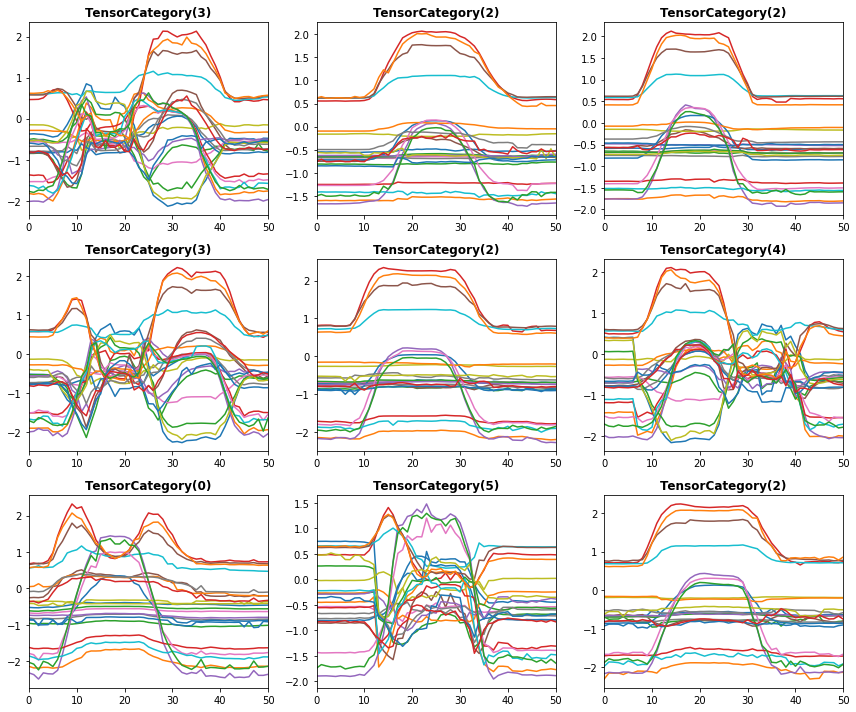

In [25]:
dls.show_batch()

In [26]:
def cycle_dl(dl):
    for x,y in iter(dl): pass

In [27]:
tfms = [[ToTSTensor], [Categorize()]]
X = np.random.rand(1000, 6, 512)
y = np.random.randint(0,2,1000)
rs = RandomSplitter()(y)
dsets = NumpyDatasets(X, y, tfms=tfms, splits=rs, pre_process=False)
train_dl, valid_dl = dsets.dataloaders(bs=128, val_bs=256)

In [28]:
%timeit cycle_dl(train_dl)

RuntimeError: DataLoader worker (pid 29706) is killed by signal: Unknown signal: 0. 

In [ ]:
TfmdDL??